In [1]:
from datetime import datetime
import colorsys as colors
import random
import math
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [2]:
# helpers

# plot images, list are dislayed in subplots
def plot(imgs, title=None):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    plt.figure()
        
    for i in range(len(imgs)):
        if(title is not None): 
            plt.suptitle(title)
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        # fix channels for rgb
        if len(imgs[i].shape) > 2:
            plt.imshow(imgs[i][:,:,[2,1,0]])
        else:
            plt.imshow(imgs[i])
        

# create empty list of given size
def empty(size):
    return [None]*size


def empty_dict(chunk, n_features):
    n_samples = chunk['n_samples']
    
    new_dict = {
        'n_samples':  n_samples,
        'n_features': n_features,
        'values':     np.zeros((n_samples, n_features)),
        'label':      np.zeros(n_samples),
        'valid':      np.zeros(n_samples),
        'weight':     np.zeros(n_samples),
        'subject':    np.zeros(n_samples),
    }
    
    new_dict['label'  ][:] = chunk['label'  ][:]
    new_dict['valid'  ][:] = chunk['valid'  ][:]
    new_dict['weight' ][:] = chunk['weight' ][:]
    new_dict['subject'][:] = chunk['subject'][:]
    
    return new_dict

# load data set
def load_chunk(set_name, chunk_nr):
    
    path = './data_pp/%s_%i.pkl' % (set_name, chunk_nr)
    
    chunk = pickle.load(open(path, 'rb'))
    
    print('load_chunk: loaded %i samples (from %s)' % (chunk['n_samples'], path))
    
    return chunk
    
# dump feature set
def dump_chunk(set_name, chunk_nr, feature_name, features):
    
    # set NaNs to 0
    vals = features['values']
    vals[np.isnan(vals)] = 0
    
    path = './features/%s_%i-%s.pkl' % (set_name, chunk_nr, feature_name)
    
    pickle.dump(features, open(path, 'wb'))
    
    print('dump_chunk: dumped %i samples (to %s)' % (chunk['n_samples'], path))


def blockshaped(a, block_size):
    (n_rows, n_cols) = block_size
    h, w = a.shape
    return (a.reshape(h//n_rows, n_rows, -1, n_cols).swapaxes(1,2).reshape(-1, n_rows, n_cols))
    
print('done')

done


In [3]:
def hog_features(chunk, img_type=None):
    
    # hog params
    orientations=8
    pixels_per_cell=(20,20)
    cells_per_block=(4,4)
    visualize=False
    
    n_values = 1152
    
    # init container
    features = empty_dict(chunk, 11*n_values)
    
    for i in range(chunk['n_samples']):
        
        if not (i+1)%2000:
            print('hog_features: %i' % (i+1))
        
        if not chunk['valid'][i]:
            continue
        
        # feature container
        vals = features['values'][i, :]
        
        # grayscale
        gs = cv2.cvtColor(chunk['rgb'][i], cv2.COLOR_RGB2GRAY)
        vals[0*n_values:1*n_values] = feature.hog(gs, orientations, pixels_per_cell, cells_per_block, visualize)
        
        # red, green, blue channels
        rc,gc,bc = cv2.split(chunk['rgb'][i])
        vals[1*n_values:2*n_values] = feature.hog(rc, orientations, pixels_per_cell, cells_per_block, visualize)
        vals[2*n_values:3*n_values] = feature.hog(gc, orientations, pixels_per_cell, cells_per_block, visualize)
        vals[3*n_values:4*n_values] = feature.hog(bc, orientations, pixels_per_cell, cells_per_block, visualize)

        # depth
        dm = chunk['dep'][i]
        vals[4*n_values:5*n_values] = feature.hog(dm, orientations, pixels_per_cell, cells_per_block, visualize)
        
        # segmentation
        sm = chunk['seg'][i][:, :, 0]
        vals[5*n_values:6*n_values] = feature.hog(sm, orientations, pixels_per_cell, cells_per_block, visualize)
        
        # depth cut
        dep = chunk['dep'][i]

        cut = 127
        while (dep<cut).sum() > 750:
            cut -= 1

        stop = False

        while not stop:
            mask = np.zeros((126,126))

            for x in range(0,7):
                for y in range(0,7):
                    mask[x:126-(6-x),y:126-(6-y)] += dep<cut

            mask = mask[3:123,3:123]
            mask = mask*(mask>24)

            stop = ((mask>0).sum()>500) or cut==127

            if not stop:
                cut += 1
                
        vals[6*n_values:7*n_values] = feature.hog(dep*mask, orientations, pixels_per_cell, cells_per_block, visualize)
        
        # hue filter
        h_min, h_max = 0, 50
        h_min2, h_max2 = 150, 200
        s_min, s_max = 60, 180
        v_min, v_max = 30, 180
        
        rgb = chunk['rgb'][i].copy()

        hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
        hsv[:,:,0] = (hsv[:,:,0]+20)%255
        
        vals[7*n_values:8*n_values] = feature.hog(hsv[:,:,0], orientations, pixels_per_cell, cells_per_block, visualize)
        vals[8*n_values:9*n_values] = feature.hog(hsv[:,:,1], orientations, pixels_per_cell, cells_per_block, visualize)
        vals[9*n_values:10*n_values] = feature.hog(hsv[:,:,2], orientations, pixels_per_cell, cells_per_block, visualize)

        mean = int(hsv[:,:,1].mean())
        if mean<60:
            hsv[:,:,1] += (60-mean)

        skin = np.ones((120,120))

        skin *= (hsv[:,:,0]>h_min)*(hsv[:,:,0]<h_max)
        skin *= (hsv[:,:,1]>v_min)*(hsv[:,:,1]<v_max)
        skin *= (hsv[:,:,2]>s_min)*(hsv[:,:,2]<s_max)

        if skin.sum()<600:
            skin += (hsv[:,:,0]>h_min2)*(hsv[:,:,0]<h_max2)
            skin *= (hsv[:,:,1]>v_min)*(hsv[:,:,1]<v_max)
            skin *= (hsv[:,:,2]>s_min)*(hsv[:,:,2]<s_max)
                
        vals[10*n_values:11*n_values] = feature.hog(skin, orientations, pixels_per_cell, cells_per_block, visualize)

    return features


        
def sift_features(chunk, img_type=None):
    
    # sift params
    step_size = 20
    sift = cv2.xfeatures2d.SIFT_create()
    
    n_values = 30*128
    
    # init container
    features = empty_dict(chunk, 2*n_values)
    
    for i in range(chunk['n_samples']):
        
        if not (i+1)%2000:
            print('sift_features (%s): %i' % (img_type, i+1))
        
        if not chunk['valid'][i]:
            continue
        
        # depth
        img = chunk['dep'][i]
    
        grid = [cv2.KeyPoint(x, y, step_size)
                for y in range(10, img.shape[0]-10, step_size)
                    for x in range(0, img.shape[1], step_size)]
        
        features['values'][i, :n_values] = sift.compute(img, grid)[1].ravel()
        
        # hue
        rgb = chunk['rgb'][i].copy()

        hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
        hsv[:,:,0] = (hsv[:,:,0]+20)%255
        
        features['values'][i, n_values:] = sift.compute(hsv[:,:,0], grid)[1].ravel()
        
    return features


def diff_features(chunk, img_type):
    
    # diff params
    block_size = (3, 3)
    block_area = block_size[0]*block_size[1]
    n_values = (120*60)//block_area
    
    # init container
    features = empty_dict(chunk, 3*n_values)
    
    for i in range(chunk['n_samples']):
        
        if not (i+1)%2000:
            print('diff_features (%s): %i' % (img_type, i+1))
        
        if not chunk['valid'][i]:
            continue
        
        img = chunk[img_type][i]
        
        l = img[:, :60].T
        r = np.flip(img[:, 60:], 1).T
        
        l_sums = [a.sum() for a in blockshaped(l, block_size)]
        r_sums = [a.sum() for a in blockshaped(r, block_size)]
        
        features['values'][i, :n_values] = np.array(l_sums, int) - np.array(r_sums, int)
        features['values'][i, n_values:] = np.concatenate((l_sums, r_sums))
        
    return features
        

extractors = {
    'hog': hog_features,
    'sift': sift_features,
    'diff': diff_features,
}

In [4]:
set_name = 'train'
chunk_nr = 0
extractor = 'diff'
img_type = 'dep'
iteration = 0

In [5]:
chunk = load_chunk(set_name, chunk_nr)
print('done')

load_chunk: loaded 20000 samples (from ./data_pp/train_0.pkl)
done


3066206


/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


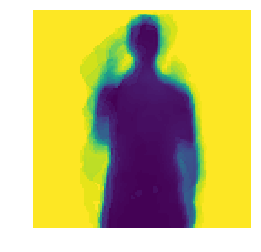

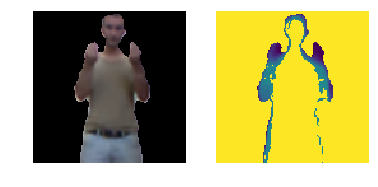

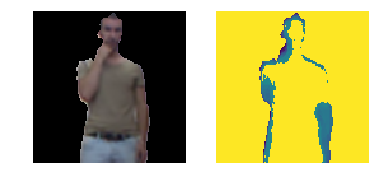

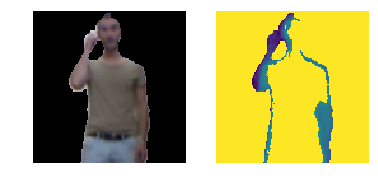

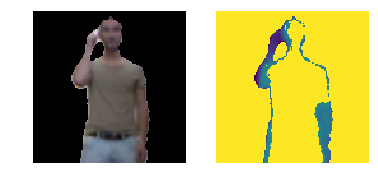

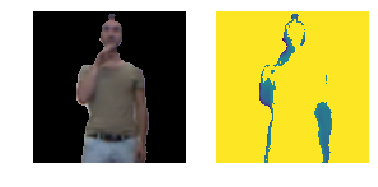

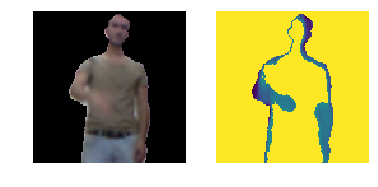

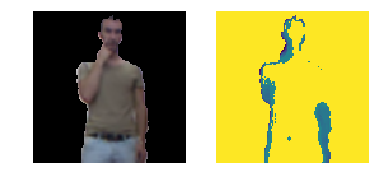

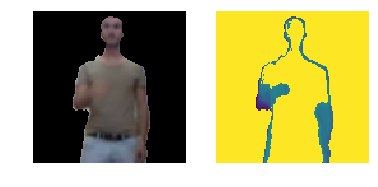

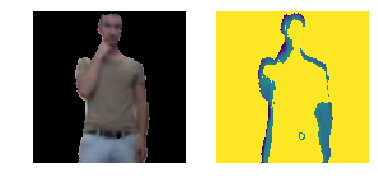

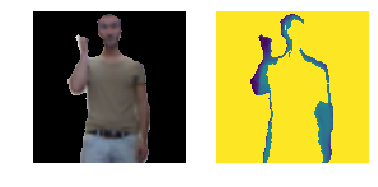

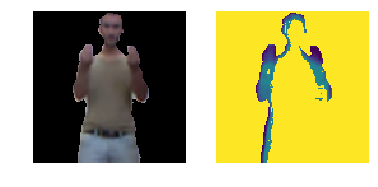

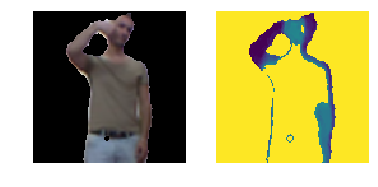

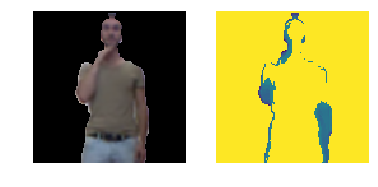

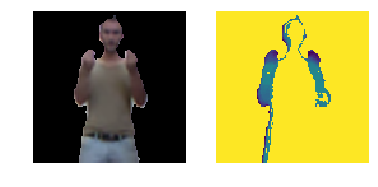

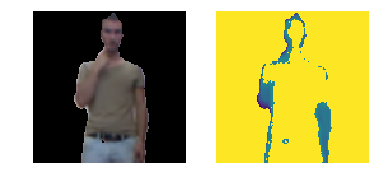

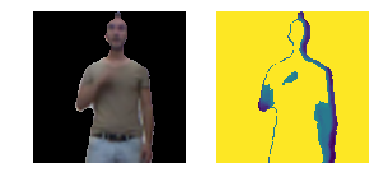

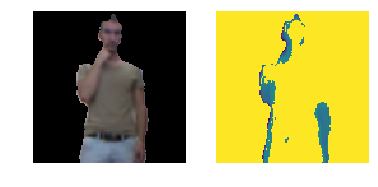

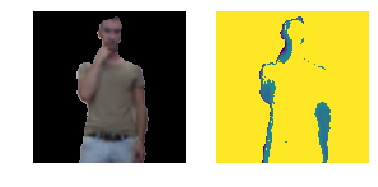

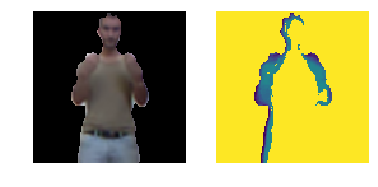

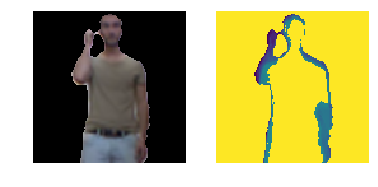

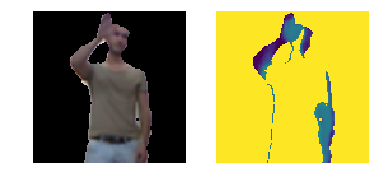

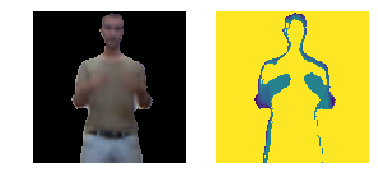

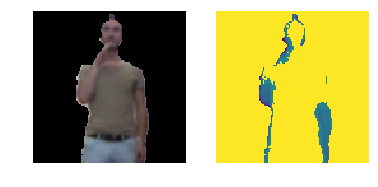

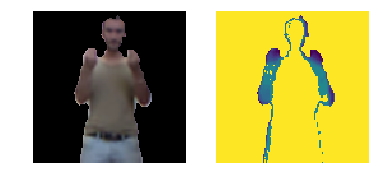

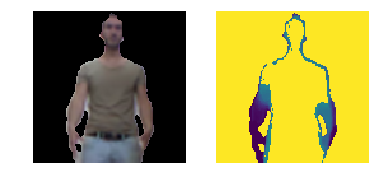

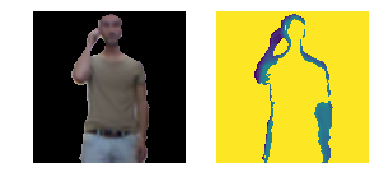

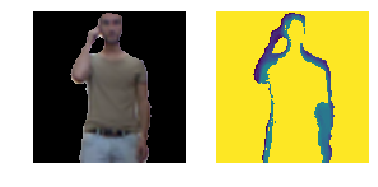

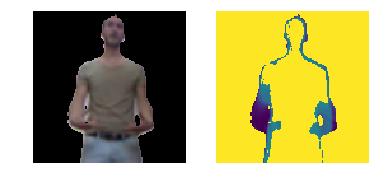

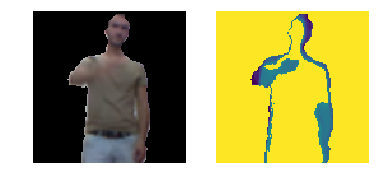

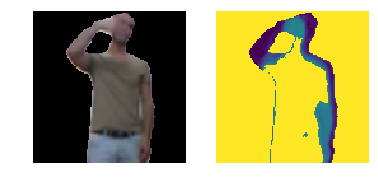

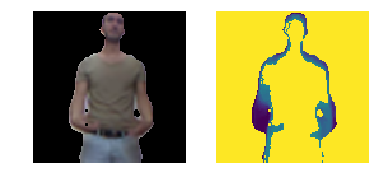

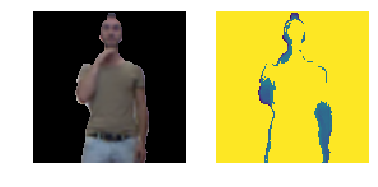

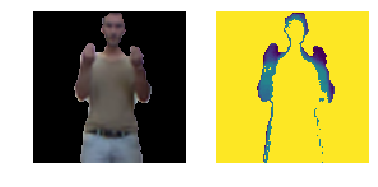

In [46]:
subject = 159

mean = np.zeros((120,120), dtype=int)
count = 0

for i in range(chunk['n_samples']//2):
    if chunk['subject'][i]==subject:
#         plot(chunk['rgb'][i])
        mean += chunk['dep'][i]
        count += 1
        
mean = (mean//count)
# mean[mean>(count*8)] = 0
plot(mean.astype(np.uint8))
print(mean.sum())

for i in range(chunk['n_samples']//2):
    if chunk['subject'][i]==subject:
        diff = chunk['dep'][i].copy().astype(int)-mean
#         diff *= 5
        diff += 127
        diff[diff<0] = 0
        diff[diff>120] = 255
        diff = diff.astype(np.uint8)
        plot([chunk['rgb'][i], diff])

In [6]:
start = datetime.now()

features = extractors[extractor](chunk, img_type)
print(features['values'].shape)

print(datetime.now()-start)

diff_features (dep): 2000
diff_features (dep): 4000
diff_features (dep): 6000
diff_features (dep): 8000
diff_features (dep): 10000
diff_features (dep): 12000
diff_features (dep): 14000
diff_features (dep): 16000
diff_features (dep): 18000
diff_features (dep): 20000
(20000, 2400)
0:00:57.055939


In [7]:
dump_chunk(set_name, chunk_nr, '%s_%s_%i' % (extractor, img_type, iteration), features)

dump_chunk: dumped 20000 samples (to ./features/train_0-diff_dep_0.pkl)
